In [1]:
!pip install wordcloud
!pip3 install scikit-learn
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from wordcloud import WordCloud
import numpy as np
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

We will first read the .csv files for the first and the second Presidential debate of 2020. Then we will combine these files by merging them.

In [2]:
pd.options.mode.chained_assignment = None
path = '/Users/nikhil/data/ML_examples/erdos/'

speech_data = pd.read_csv('finaldata_party.csv')
speech_data.head()

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,D
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,D
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,R
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,D
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,R


Perform a train test split

In [3]:
train_speech,test_speech = train_test_split(speech_data.copy(),test_size=0.3, random_state=42)

Lets define the column transformer class. The column transformer will select only those rows from the data frame where the speaker is Joe Biden and Donald Trump (We will ignore text from Chris Wallace as he is the mediator). The column transformer will then add a target column to the data frame. The value in the target column for rows with speaker as Joe Biden  will be 1 and the value in the target column for rows with speaker as Donald Trump will be 0 (1 indicating that the candiddate got elected as the President and 0 otherwise).

In [4]:
class Custom_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self,min_date,max_date,type):
        '''
        Inputs: 
        min_date: Select the start date, format: "YYYY-MM-DD",(if None selects all dates)
        max_date: Select the end date, format: "YYYY-MM-DD",(if None selects all dates)
        type: List of debate types, e.g ['VP','Pres','Dem','Rep'],(if None all types will be considered)
        
        Output:
        Debate Date, Debate Type selected data frame which contains only the 'Democratic' and 'Republican' party debates
        with targets 0 for 'Republican' and 1 for 'Democratic'
        '''
        self.min_date = min_date
        self.max_date = max_date
        self.type = type
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.min_date!=None and self.max_date!=None:
            X['date'] = pd.to_datetime(X['date'])
            date_mask = (X['date'] > self.min_date) & (X['date'] <= self.max_date)
            masked_data = X.loc[date_mask]
        else:
            masked_data = X
    
        if self.type!=None:
            masked1_data = masked_data.loc[masked_data['type'].isin(self.type)]
        else:
            masked1_data = masked_data
        masked2_data = masked1_data.loc[masked_data['party'].isin(['R','D'])]
        masked2_data.loc[masked2_data['party'] == 'R', 'party'] = 0
        masked2_data.loc[masked2_data['party'] == 'D', 'party'] = 1
        masked2_data['party'] = masked2_data['party'].astype(int)
        return masked2_data

In [5]:
#Set True for bigrams otherwise set False for unigrams
Transformer = Custom_Transformer(min_date=None,max_date=None,type=None)

df_new_train = Transformer.fit_transform(train_speech)
df_new_test =  Transformer.fit_transform(test_speech)
print(df_new_train['speaker'].unique())
df_new_train.head()

['Bob Dole' 'Lloyd Bentsen' 'Donald Trump' 'Jim Webb' 'Elizabeth Warren'
 'Dan Quayle' 'Mitt Romney' 'Jeb Bush' 'Hillary Clinton' 'Tim Kaine'
 'Marco Rubio' 'Tom Steyer' 'Rick Perry' 'Paul Ryan' 'Kamala Harris'
 'Newt Gingrich' 'Ben Carson' 'Richard Nixon' 'Amy Klobuchar'
 'Andrew Yang' 'Joe Biden' 'Bernie Sanders' 'Michael Dukakis'
 'Michael Bennett' 'Cory Booker' 'Mike Pence' 'Al Gore' "Beto O'Rourke"
 'Jimmy Carter' 'John Kerry' 'George W. Bush' 'John Delaney'
 'Barack Obama' 'Bill Clinton' 'Pete Buttigieg' 'Walter Mondale'
 'Carly Fiorina' "Martin O'Malley" 'John McCain' 'John Edwards'
 'John Hickenlooper' 'Tulsi Gabbard' 'Herman Cain' 'Julian Castro'
 'Rick Santorum' 'John Kennedy' 'Gerald Ford' 'Chris Christie'
 'John Kasich' 'Mike Huckabee' 'Kirsten Gillibrand' 'George H. W. Bush'
 'Rand Paul' 'Michael Bloomberg' 'Dick Cheney' 'Tim Ryan' 'Bill DeBlasio'
 'Ronald Reagan' 'Lincoln Chafee' 'Ted Cruz' 'Scott Walker'
 'Marianne Williamson' 'Jack Kemp' 'Geraldine Ferraro' 'Jon Huntsma

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
1414,1414,Bob Dole,Let me get out of your way here.,Pres,1996.0,1996-10-16,1.0,0,0
540,540,Lloyd Bentsen,All right.,VP,1988.0,1988-10-05,1.0,0,1
7216,7216,Donald Trump,So important. It just shows that he has no und...,Pres,2020.0,2020-10-22,1.0,0,0
6018,6018,Jim Webb,I'd have to say the enemy soldier that threw t...,Dem,2016.0,2015-10-13,1.0,0,1
8835,8835,Elizabeth Warren,So I understand that what we're all looking fo...,Dem,2020.0,2019-10-15,1.0,0,1


Define the TF-IDF vectorizer by using ngrams = (1,1) for unigrams and ngrams = (2,2) for bigrams.

In [6]:
bigrams = False
if bigrams:
   ngrams = (2,2)
else:
   ngrams = (1,1)

Tfidf = sk_text.TfidfVectorizer(max_features=5000,lowercase=True,analyzer='word',stop_words='english',ngram_range=ngrams)


Separate the X and y for training and test data set. X is the 'text' column and y is the 'target' column.

In [7]:
X = df_new_train['text']
y = df_new_train['party']
X_test = df_new_test['text']
y_test = df_new_test['party']
Tfidf.fit_transform(df_new_train['text'])


<7611x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 215222 stored elements in Compressed Sparse Row format>

Lets generate a pipeline called Voting_classifier. The pipeline will initially convert the 'text' column from the input data to a sparse matrix of words using the TF-IDF vectorizer and feed that sparse matrix to sklearn's Multinomial Naive Bayes estimator. The Pipeline function is very useful when we are dealing with huge NLP data sets which require a lot of preprocessing before feeding it to the model. The Pipeline function can also be used for hyper-parametrer tuning using MyGridSearchCV.

In [8]:
Voting_classifier = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])

Fit the Voting_classifier to the train data and make predictions on the test data.

In [9]:
Voting_classifier.fit(X,y)
y_predict = Voting_classifier.predict(X_test)
y_predict_train = Voting_classifier.predict(X)

Some metrics

/home/aniket/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.44      0.56      1265
           1       0.72      0.92      0.81      1989

    accuracy                           0.73      3254
   macro avg       0.75      0.68      0.69      3254
weighted avg       0.75      0.73      0.71      3254



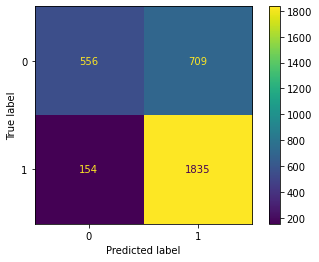

In [10]:
plot_confusion_matrix(Voting_classifier, X_test, y_test)
print(classification_report(y_test, y_predict))

/home/aniket/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.90      0.56      0.69      3075
           1       0.76      0.96      0.85      4536

    accuracy                           0.80      7611
   macro avg       0.83      0.76      0.77      7611
weighted avg       0.82      0.80      0.79      7611



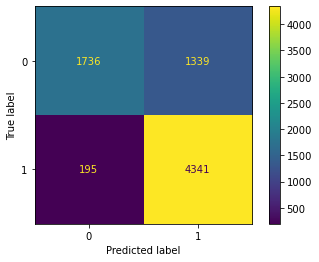

In [11]:
plot_confusion_matrix(Voting_classifier, X, y)
print(classification_report(y, y_predict_train))

During training, the multinomial naive bayes calculates probabilities such as $Pr(\textrm{'Great'}\ |\ \textrm{Win}),$ the probability that the word "Great" appears in the candidate's speech, given that the candidate has won the election.  Using these probabilities, we can define a **polarity score** for each word $w$,

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{won})}{Pr(w\ |\ \textrm{lost})}\right).$$

Polarity analysis is an example where a simpler model (naive Bayes) offers more explicability than more complicated models.  Aside from this, naive Bayes models are easy to train, the training process is parallelizable, and these models lend themselves well to online learning.  Given enough training data, naive Bayes models have performed well in NLP applications such as spam filtering.

Speaking in terms of python code, the command  "**voting_classifier['Tfidf vectorizer'].get_feature_names_out()**"  will give you a list of filtered words that were used as features in the multinomial naive bayes method. We can get **$\log(Pr(w\ |\ \textrm{won}))$** and **$\log(Pr(w\ |\ \textrm{lost}))$** by using the sklearn's "**model.feature_log_prob**" command as follows,

$\log(Pr(w\ |\ \textrm{won}))$ = classifier['Multinomial NB'].feature_log_prob_[1]

$\log(Pr(w\ |\ \textrm{lost}))$ = classifier['Multinomial NB'].feature_log_prob_[0]

Using this, we can calculate the polarity score for all the words.

Some of the words that the TF-IDF vectorizer uses as features are given below

In [12]:
words = Voting_classifier['Tfidf vectorizer'].get_feature_names_out()

words

array(['00', '000', '01', ..., 'zero', 'zone', 'zones'], dtype=object)

In [13]:
def get_polar_words(classifier,top):
    coeff_pos = classifier['Multinomial NB'].feature_log_prob_[1]
    coeff_neg = classifier['Multinomial NB'].feature_log_prob_[0]
    words = classifier['Tfidf vectorizer'].get_feature_names_out()
    words_join=[]
    for w in words:
        words_join.append(w.replace(" ", "_"))
    words_join = np.array(words_join)
    polarity = coeff_pos-coeff_neg
    polarity_sorted = np.sort(polarity)
    index_sort = np.argsort(polarity)
    words_sorted = words_join[index_sort]
    words_positive = words_sorted[-top:]
    words_negative = words_sorted[:top]
    wc1 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_positive))
    wc2 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_negative))
    return wc1,wc2,words_join


Lets plot the top 50 most polar words

[]

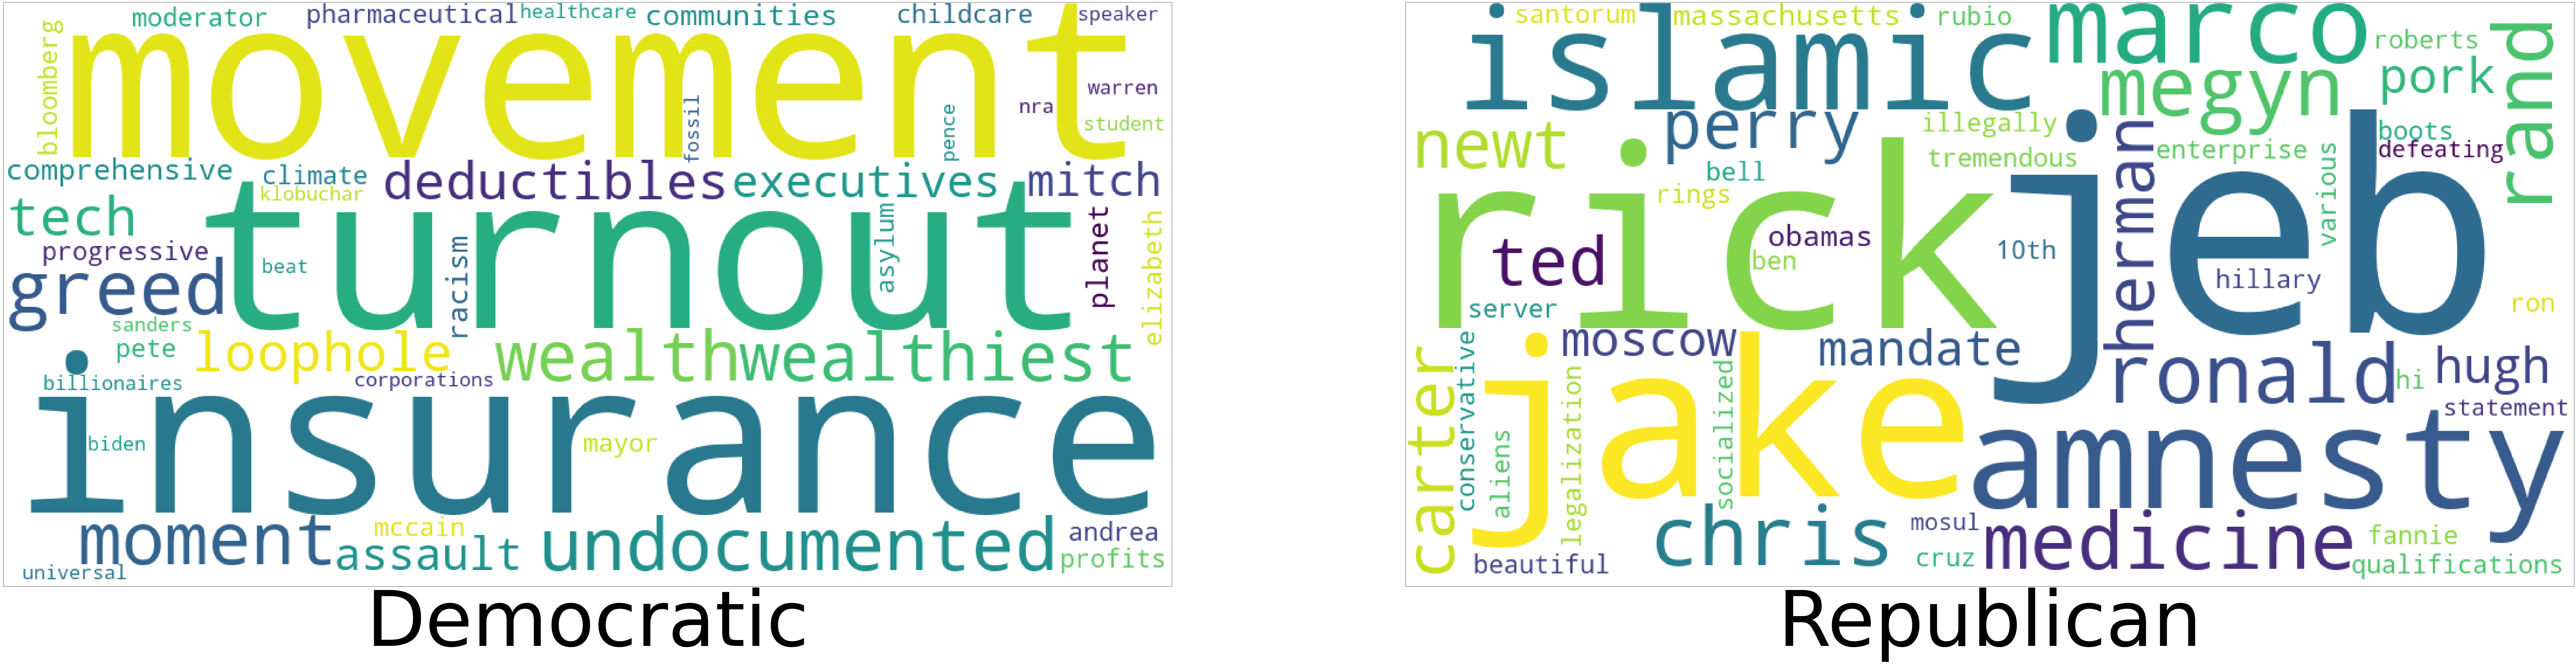

In [14]:
wc1,wc2,feature_names = get_polar_words(Voting_classifier,50)

f = plt.figure(figsize=(150,50))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(wc1)
ax1.set_xlabel('Democratic',fontsize=250)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2)
ax2.set_xlabel('Republican',fontsize=250)
ax2.set_xticks([])
ax2.set_yticks([])



In [15]:
!pip3 show scikit-learn

Name: scikit-learn
Version: 1.1.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /home/aniket/anaconda3/lib/python3.8/site-packages
Requires: numpy, scipy, threadpoolctl, joblib
Required-by: sklearn
